Source: https://www.tensorflow.org/tutorials/

In [5]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

ImportError: cannot import name 'builder' from 'google.protobuf.internal' (c:\Users\mohitvyas\Miniconda3\envs\tf\lib\site-packages\google\protobuf\internal\__init__.py)

In [4]:
import google.protobuf
print(google.protobuf.__version__)

3.19.6


In [2]:
print(tf.__version__)

2.10.1


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 32s 0us/step


In [4]:
print (os.listdir(dataset_dir))

train_dir = os.path.join(dataset_dir, 'train')
print (os.listdir(train_dir))

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']
['labeledBow.feat', 'neg', 'pos', 'unsup', 'unsupBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


In [5]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Detour: understanding TextVectorization layer

In [42]:
# toy example-1: construct vocabulary from input data
max_tokens = 5  # Maximum vocab size.
max_len = 4  # Sequence length to pad the outputs to.
# Create the layer.
vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_len)

# Now that the vocab layer has been created, call `adapt` on the
# list of strings to create the vocabulary.
vectorize_layer.adapt(["foo bar", "bar baz", "baz bada boom"])

# see vocabulary
print (vectorize_layer.get_vocabulary()) # it is a list of words in the vocabulary

# Now, the layer can map strings to integers -- you can use an
# embedding layer to map these integers to learned embeddings.
input_data = [["foo \nqux  bar\t\t\n"], # multiple spaces, tabs, and newline characters are all ignored by default split function
              ["baz boom"], # boom is not in the vocabulary due to max_tokens
              ["a b foo bar baz"]] # long sentence is truncated to max_len
print (vectorize_layer(input_data)) # output mode is int so output is the index of the word in the vocabulary

['', '[UNK]', 'baz', 'bar', 'foo']
tf.Tensor(
[[4 1 3 0]
 [2 1 0 0]
 [1 1 4 3]], shape=(3, 4), dtype=int64)


In [46]:
# toy example-2: pass custom vocabulary
vocab_data = ["earth", "wind", "and", "fire"]
max_tokens = 1000  # Maximum vocab size.
max_len = 4  # Sequence length to pad the outputs to.
# Create the layer, passing the vocab directly. You can also pass the
# vocabulary arg a path to a file containing one vocabulary word per
# line.
vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_len,
    vocabulary=vocab_data)

# Because we've passed the vocabulary directly, we don't need to adapt
# the layer - the vocabulary is already set. The vocabulary contains the
# padding token ('') and OOV token ('[UNK]')
# as well as the passed tokens.
print (vectorize_layer.get_vocabulary())

input_data = [["earth \nqux  fire\t\t\n"], # multiple spaces, tabs, and newline characters are all ignored by default split function
              ["wind and"], # boom is not in the vocabulary due to max_tokens
              ["a b earth fire wind"]] # long sentence is truncated to max_len
print (vectorize_layer(input_data)) # output mode is int so output is the index of the word in the vocabulary

['', '[UNK]', 'earth', 'wind', 'and', 'fire']
tf.Tensor(
[[2 1 5 0]
 [3 4 0 0]
 [1 1 2 5]], shape=(3, 4), dtype=int64)


In [58]:
# explore different output modes: int, multi_hot, count, tf_idf
vocab_data = ["earth", "wind", "and", "fire"]
max_len = 4  # only valid for output_mode='int'. None means the output_sequence_length is picked based on the maximum sequence length in the input data
vectorize_layer = layers.TextVectorization(output_mode='int', output_sequence_length=max_len, vocabulary=vocab_data)
print (vectorize_layer.get_vocabulary())
print (vectorize_layer([["wind and"], ["a b earth fire wind c d d e"]]))
print ("\n-----------\n")

# multi_hot => output a 0/1 bit mask where output[i] is 1 if the word in the vocabulary at index i is present in the input and 0 otherwise
vectorize_layer = layers.TextVectorization(output_mode='multi_hot', output_sequence_length=None, vocabulary=vocab_data)
print (vectorize_layer.get_vocabulary())
print (vectorize_layer([["wind and"], ["a b earth fire wind c d d e earth"]]))
print ("\n-----------\n")

# count => same as multi_hot but output[i] is the count of the word in the input
vectorize_layer = layers.TextVectorization(output_mode='count', output_sequence_length=None, vocabulary=vocab_data)
print (vectorize_layer.get_vocabulary())
print (vectorize_layer([["wind and"], ["a b earth fire wind c d d e earth"]]))
print ("\n-----------\n")

# tf_idf => same as count and multi_hot but output[i] is the tf-idf value of the word in the input
vectorize_layer = layers.TextVectorization(output_mode='tf_idf', output_sequence_length=None)
vectorize_layer.adapt(["wind and", "earth fire wind earth"]) # need to call adapt to calculate the idf values or else pass the idf values directly along with the vocabulary

print (vectorize_layer.get_vocabulary())
print (vectorize_layer([["wind and"], ["a b earth fire wind wind d d e earth"]]))

['', '[UNK]', 'earth', 'wind', 'and', 'fire']
tf.Tensor(
[[3 4 0 0]
 [1 1 2 5]], shape=(2, 4), dtype=int64)

-----------

['[UNK]', 'earth', 'wind', 'and', 'fire']
tf.Tensor(
[[0. 0. 1. 1. 0.]
 [1. 1. 1. 0. 1.]], shape=(2, 5), dtype=float32)

-----------

['[UNK]', 'earth', 'wind', 'and', 'fire']
tf.Tensor(
[[0. 0. 1. 1. 0.]
 [6. 2. 1. 0. 1.]], shape=(2, 5), dtype=float32)

-----------

['[UNK]', 'wind', 'earth', 'fire', 'and']
tf.Tensor(
[[0.         0.51082563 0.         0.         0.6931472 ]
 [3.237834   1.0216513  1.3862944  0.6931472  0.        ]], shape=(2, 5), dtype=float32)


In [64]:
# try ngram param to see what kind of ngrams are generated
vectorize_layer = layers.TextVectorization(output_mode='int', output_sequence_length=7, ngrams=5)
vectorize_layer.adapt(["wind and fire", "earth fire wind earth"]) 

"""
1. makes up new tokens in input if an ngram is matched: wind and fire => wind, and, fire, wind and, and fire, wind and fire
2. creates all possible ngrams and adds them to the vocabulary
"""

print (vectorize_layer.get_vocabulary())
print (vectorize_layer([["wind and fire"], ["a b earth fire wind wind d d e earth"]]))

['', '[UNK]', 'wind', 'fire', 'earth', 'wind earth', 'wind and fire', 'wind and', 'fire wind earth', 'fire wind', 'earth fire wind earth', 'earth fire wind', 'earth fire', 'and fire', 'and']
tf.Tensor(
[[ 2 14  3  7 13  6  0]
 [ 1  1  4  3  2  2  1]], shape=(2, 7), dtype=int64)


In [66]:
# try ngram param again but pass a tuple of integers instead
vectorize_layer = layers.TextVectorization(output_mode='int', output_sequence_length=7, ngrams=(2, 4))
vectorize_layer.adapt(["wind and fire", "earth fire wind earth"]) 

"""
includes all ngrams of size 2 and 4 only
"""

print (vectorize_layer.get_vocabulary())
print (vectorize_layer([["wind and fire"], ["a b earth fire wind wind d d e earth"]]))

['', '[UNK]', 'wind earth', 'wind and', 'fire wind', 'earth fire wind earth', 'earth fire', 'and fire']
tf.Tensor(
[[3 7 0 0 0 0 0]
 [1 1 6 4 1 1 1]], shape=(2, 7), dtype=int64)


End of detour. Back to the main program.

In [67]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [68]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [69]:
print (len(train_text))
for text_batch in train_text.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])

625
Review b"The idea ia a very short film with a lot of information. Interesting, entertaining and leaves the viewer wanting more. The producer has produced a short film of excellent quality that cannot be compared to any other short film that I have seen. I have rated this film at the highest possible rating. I also recommend that it is shown to office managers and business people in any establishment. What comes out of it is the fact that people with ideas are never listened to, their voice is never heard. It is a lesson to be learned by any office that wants to go forward. I hope that the produced will produce a second part to this 'idea'. I look forward to viewing the sequence. Once again congrats to Halaqah media in producing a film of excellence and quality with a lesson in mind."
Review b"When the Chamberlain family is camping near Ayers Rock, Australia, Lindy Chamberlain (Meryl Streep) sees her baby being dragged out of their tent by a dingo and then begins an ordeal that no o

In [70]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [71]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"A young woman suffers from the delusion that she is a werewolf, based upon a family legend of an ancestor accused of and killed for allegedly being one. Due to her past treatment by men, she travels the countryside seducing and killing the men she meets. Falling in love with a kind man, her life appears to take a turn for the better when she is raped and her lover is killed by a band of thugs. Traumatized again by these latest events, the woman returns to her violent ways and seeks revenge on the thugs," according to the DVD sleeve\'s synopsis.<br /><br />Rino Di Silvestro\'s "La lupa mannara" begins with full frontal, writhing, moaning dance by shapely blonde Annik Borel, who (as Daniella Neseri) mistakenly believes she is a werewolf. The hottest part is when the camera catches background fire between her legs. The opening "flashback" reveals her hairy ancestor was (probably) a lycanthropic creature. Ms. Borel is, unfortunately, not a werewolf; she is merely a very

In [72]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  lovely
 313 --->  american
Vocabulary size: 10000


In [73]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [74]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [75]:
embedding_dim = 16

In [76]:
"""
Intuition:
- embedding of a word quantifies how negative it is in various ways
- average pooling just checks how negative are the bag of words overall in the review

Relative order of words is not used. 
When overfitting, it will assign very negative or very positive embeddings
to words that just appear once to make sure that training sample gets properly 
classified. 
"""

model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
__________________________________________________

In [77]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [78]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 27s 41ms/step - loss: 0.6662 - binary_accuracy: 0.6849 - val_loss: 0.6188 - val_binary_accuracy: 0.7690
Epoch 2/10
625/625 [==============================] - 9s 14ms/step - loss: 0.5517 - binary_accuracy: 0.7990 - val_loss: 0.5010 - val_binary_accuracy: 0.8212
Epoch 3/10
625/625 [==============================] - 7s 12ms/step - loss: 0.4469 - binary_accuracy: 0.8439 - val_loss: 0.4225 - val_binary_accuracy: 0.8444
Epoch 4/10
625/625 [==============================] - 10s 16ms/step - loss: 0.3803 - binary_accuracy: 0.8648 - val_loss: 0.3757 - val_binary_accuracy: 0.8598
Epoch 5/10
625/625 [==============================] - 7s 12ms/step - loss: 0.3366 - binary_accuracy: 0.8769 - val_loss: 0.3466 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3058 - binary_accuracy: 0.8887 - val_loss: 0.3272 - val_binary_accuracy: 0.8706
Epoch 7/10
625/625 [==============================] - 7s

In [79]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 110s 140ms/step - loss: 0.3108 - binary_accuracy: 0.8728
Loss:  0.31081873178482056
Accuracy:  0.8728399872779846


In [80]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

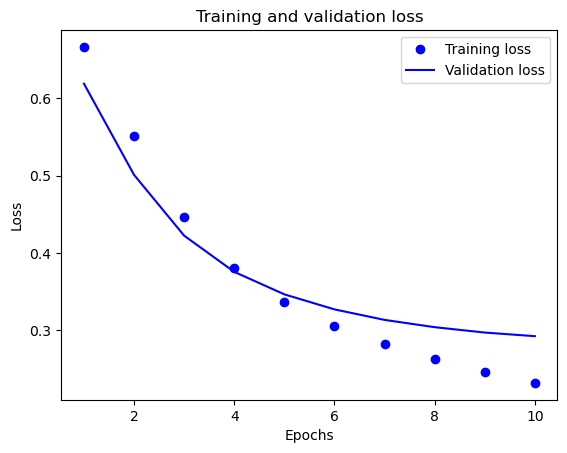

In [81]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

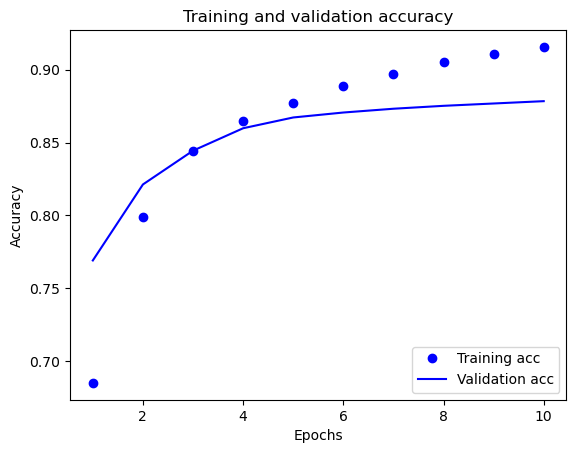

In [82]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [85]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  # this is a bug in the documentation example. sigmoid is already present in the model
  # adding it here again results in low accuracy as seen in the doc also
  # layers.Activation('sigmoid') 
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 92s 117ms/step - loss: 0.3108 - accuracy: 0.8728
0.8728399872779846


In [90]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible...",
  "terrible awful bad",
  "The movie was great and wonderful! But the popcorn we had there was terrible, awful, bad, the worst I've ever had."
])

export_model.predict(examples)

1/1 [==============================] - 0s 31ms/step


array([[0.6048751 ],
       [0.42677373],
       [0.3457392 ],
       [0.1339179 ],
       [0.12667799]], dtype=float32)